In [40]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
feature_name_df = pd.read_csv('human_activity/features.txt',
            sep='\s+',
            header=None,
            names=['column_index','column_name'])

In [42]:
feature_dup_df = feature_name_df.groupby('column_name').count()
feature_dup_df.head(1)

,column_index
column_name,
"angle(X,gravityMean)",1


In [43]:
feature_dup_df[feature_dup_df['column_index']>1].count()

column_index    42
dtype: int64

In [44]:
feature_dup_df[feature_dup_df['column_index']>1].head(2)

,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3


In [45]:
def get_new_feature_name_df(old):
    df = pd.DataFrame(data=old.groupby('column_name').cumcount(),
                 columns=['dup_cnt'])
    df = df.reset_index()
    new_df = pd.merge(old.reset_index(),df,how='outer')
    new_df['column_name'] = new_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) 
                                            if x[1] > 0 
                                            else x[0] ,axis=1)
    new_df.drop(columns=['index'],inplace=True)
    return new_df


In [46]:
df1 = get_new_feature_name_df(feature_name_df)
df1[df1['dup_cnt']>0]

,column_index,column_name,dup_cnt
316,317,"fBodyAcc-bandsEnergy()-1,8_1",1
317,318,"fBodyAcc-bandsEnergy()-9,16_1",1
318,319,"fBodyAcc-bandsEnergy()-17,24_1",1
319,320,"fBodyAcc-bandsEnergy()-25,32_1",1
320,321,"fBodyAcc-bandsEnergy()-33,40_1",1
...,...,...,...
497,498,"fBodyGyro-bandsEnergy()-17,32_2",2
498,499,"fBodyGyro-bandsEnergy()-33,48_2",2
499,500,"fBodyGyro-bandsEnergy()-49,64_2",2
500,501,"fBodyGyro-bandsEnergy()-1,24_2",2


In [47]:
feature_name_df.head(1)

,column_index,column_name
0,1,tBodyAcc-mean()-X


In [48]:
def get_human_dataset():
    feature_name_df = pd.read_csv('human_activity/features.txt',
            sep='\s+',
            header=None,
            names=['column_index','column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    x_train = pd.read_csv('human_activity/train/X_train.txt',sep='\s+',names=feature_name)
    x_test = pd.read_csv('human_activity/test/X_test.txt',sep='\s+',names=feature_name)
    y_train = pd.read_csv('human_activity/train/y_train.txt',sep='\s+',names=['action'])
    y_test = pd.read_csv('human_activity/test/y_test.txt',sep='\s+',names=['action'])
    return x_train,x_test,y_train,y_test    

In [49]:
x_train,x_test,y_train,y_test = get_human_dataset()

In [50]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [51]:
y_train.value_counts()

action
6         1407
5         1374
4         1286
1         1226
2         1073
3          986
dtype: int64

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [53]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train,y_train)
pred = dt_clf.predict(x_test)
accuracy_score(y_test,pred)

0.8547675602307431

In [34]:
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 156,
 'splitter': 'best'}

In [35]:
from sklearn.model_selection import GridSearchCV

In [37]:
%%time
param = {
    'max_depth': [6,8,10,12,16,20,24],
    'min_samples_split': [16]
}
grid_cv = GridSearchCV(dt_clf,param_grid=param,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(x_train,y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.8548794147162603
{'max_depth': 8, 'min_samples_split': 16}
CPU times: total: 1min 28s
Wall time: 1min 31s


In [38]:
cv_r = pd.DataFrame(grid_cv.cv_results_)
cv_r[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


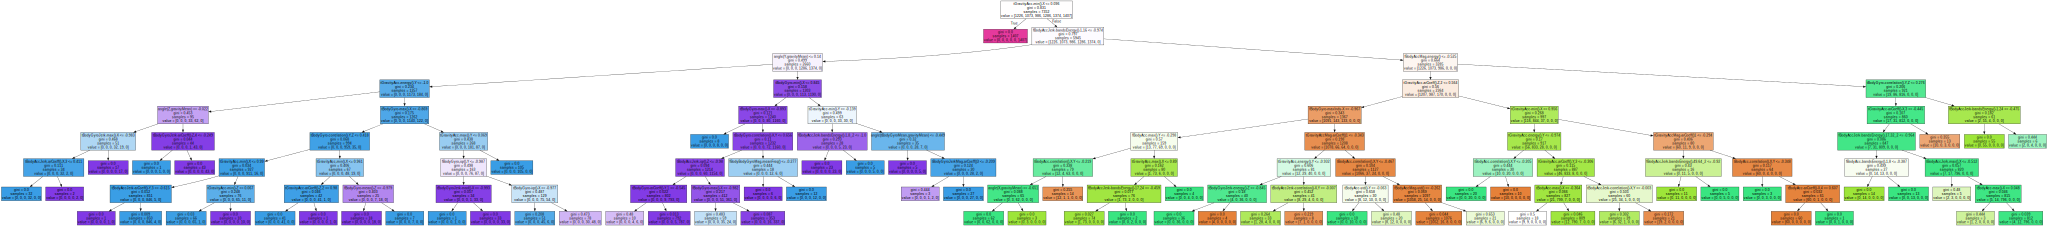

In [55]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(grid_cv.best_estimator_,
                out_file='tree1.dot',
                # class_names=iris.target_names,
                feature_names=df1['column_name'],
                filled=True)
with open('tree1.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [56]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(x_test)
accuracy_score(y_test,pred1)

0.8717339667458432

In [57]:
pred2 = dt_clf.predict(x_test)
accuracy_score(y_test,pred2)

0.8547675602307431

<Axes: >

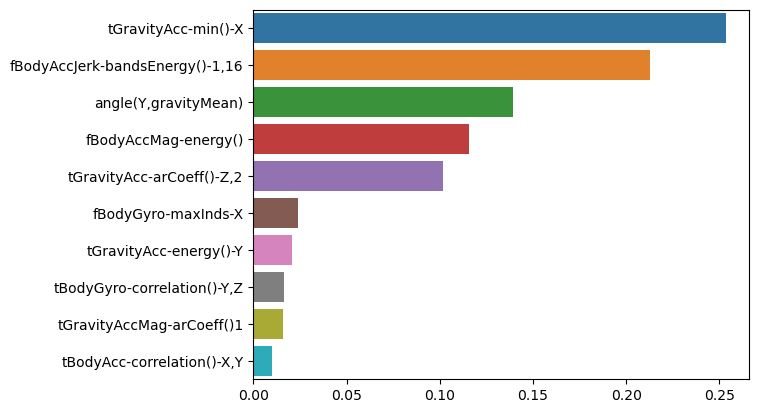

In [62]:
import seaborn as sns
ftr_im = best_df_clf.feature_importances_
ftr_im_s = pd.Series(ftr_im,index=x_train.columns)
top10 = ftr_im_s.sort_values(ascending=False)[:10]
sns.barplot(x=top10,y=top10.index)